In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.io import loadmat
from scipy.optimize import curve_fit
import scipy.stats
import itertools

from toolz.curried import *

In [2]:
n_t = 10000
low_freq = 600
high_freq = 1600
freqs = np.random.uniform(np.log(low_freq), np.log(high_freq), size=(n_t, 2))

In [3]:
is_first_bigger = lambda p: (p[:, 0] - p[:, 1]) > 0

In [4]:
def M(sigma, eta, prevM, log_f1):
    n = np.random.normal(scale=sigma)
    return (1 - eta) * (log_f1 + n) + eta * prevM

In [5]:
def M_iterator(sigma, eta, log_f1_iter):
    M_with_params = partial(M, sigma, eta)
    
    return drop(1, accumulate(M_with_params, log_f1_iter, 0))

In [6]:
def run_experiment(sigma, eta, freqs):
    Ms = list(M_iterator(sigma, eta, freqs[:, 0]))
    decisions = Ms > freqs[:, 1]
    correct_decisions = is_first_bigger(freqs)
    marks = decisions == correct_decisions
    
    return marks

In [7]:
def plot_trials(pairs, marks, diagonal=True, xymarker=1000):
    global low_freq, high_freq
    correct_incorrect_colors = lambda c_l: [ 'grey' if x else 'orange' for x in c_l ]
    ax = plt.gca()
    ax.scatter(np.exp(pairs[:, 0]), np.exp(pairs[:, 1]), c=correct_incorrect_colors(marks), s=5, alpha=0.5)
    if diagonal:
        ax.plot([low_freq, high_freq], [low_freq, high_freq], c='k')
    if xymarker:
        ax.plot([xymarker, xymarker], [low_freq, high_freq], c='k')
        ax.plot([low_freq, high_freq], [xymarker, xymarker], c='k')
    ax.set_xlabel("$f_1 [Hz]$")
    ax.set_ylabel("$f_2 [Hz]$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    ticks_range = [600, 800, 1000, 1200, 1400, 1600]
    ax.set_xticks(ticks_range)
    ax.set_yticks(ticks_range)
    ax.minorticks_off()

In [8]:
marks1 = run_experiment(0.3, 0, freqs)

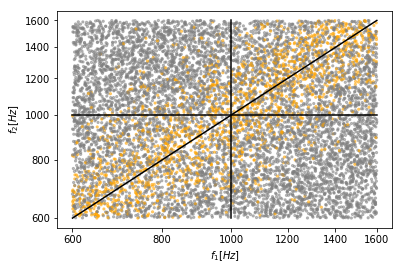

In [12]:
plot_trials(freqs, marks1)

In [13]:
def psychometric_datapoints(pairs, marks, bin_count=50):
    bin_size = len(pairs) // bin_count
    diffs = pairs[:, 0] - pairs[:, 1]
    
    sort_by_first = sorted(key=lambda p: p[0])
    aggregate = compose(map(np.mean), unzip)
    bin_data = compose(unzip,
                       map(aggregate),
                       partition_all(bin_size),
                       sort_by_first,
                       zip)

    return bin_data(diffs, marks)
   
def psychometric_plot(diffs, marks):
    plt.plot(diffs, marks)
    plt.xlabel('$log(f_1)-log(f_2)$')
    plt.ylabel('Percent of correct responses')
    
unpack_args = curry(lambda f, args: f(*args))
unzip = lambda seq: zip(*seq)

plot_psychometric = compose(unpack_args(psychometric_plot), psychometric_datapoints)

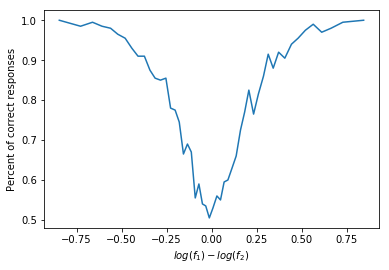

In [14]:
d, marks1_psychometric = psychometric_datapoints(freqs, marks1) 
plot_psychometric(freqs, marks1)

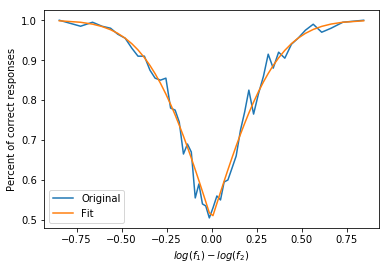

In [15]:
phi = lambda d, sigma: scipy.stats.norm.cdf(np.abs(d)/sigma)
sigma, _ = curve_fit(phi, d, marks1_psychometric)

plot_psychometric(freqs, marks1)
plt.plot(d, phi(d, sigma))
plt.legend(['Original', 'Fit'])

In [16]:
marks2 = run_experiment(0, 0.4, freqs)

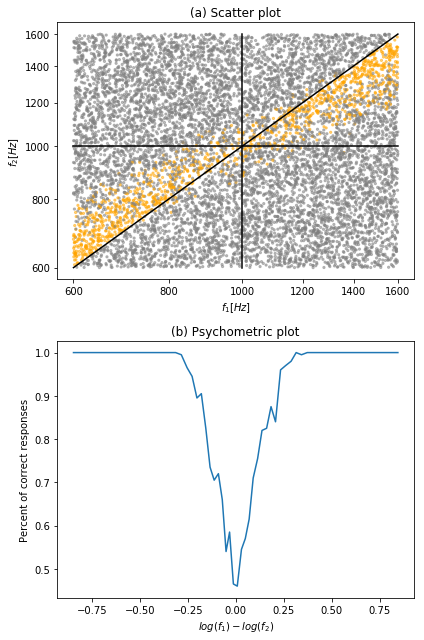

In [17]:
plt.figure(figsize=(4*1.5, 3*1.5*2))
ax = plt.subplot(211)
ax.set_title("(a) Scatter plot")
plot_trials(freqs, marks2)

ax = plt.subplot(212)
ax.set_title("(b) Psychometric plot")
plot_psychometric(freqs, marks2)

plt.tight_layout()

In [18]:
marks3 = run_experiment(0.3, 0.4, freqs)

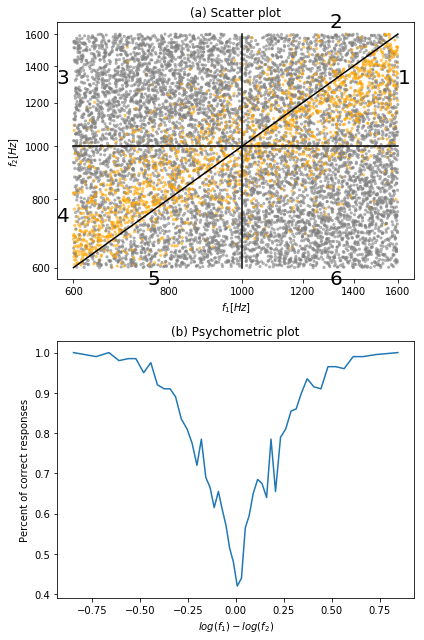

In [19]:
plt.figure(figsize=(4*1.5, 3*1.5*2))
ax = plt.subplot(211)
ax.set_title("(a) Scatter plot")
plot_trials(freqs, marks3)
plt.text(1600, 1300, '1', fontsize=20)
plt.text(1300, 1650, '2', fontsize=20)
plt.text(570, 1300, '3', fontsize=20)
plt.text(570, 730, '4', fontsize=20)
plt.text(750, 560, '5', fontsize=20)
plt.text(1300, 560, '6', fontsize=20)

ax = plt.subplot(212)
ax.set_title("(b) Psychometric plot")
plot_psychometric(freqs, marks3)

plt.tight_layout()

In [20]:
bplus = loadmat("./bias_plus.mat")
bminus = loadmat("./bias_minus.mat")

In [21]:
bplus['freqs'] = np.log(list(zip(bplus['f1'], bplus['f2']))).squeeze().T
bplus['marks'] = np.array(bplus['cor'], dtype=bool).flatten()

bminus['freqs'] = np.log(list(zip(bminus['f1'], bminus['f2']))).squeeze().T
bminus['marks'] = np.array(bminus['cor'], dtype=bool).flatten()

In [22]:
def performance_per_area(freqs, marks, xymarker=1000):
    mask_diag = is_first_bigger(freqs)
    mask_up = freqs[:, 1] > np.log(xymarker)
    mask_right = freqs[:, 0] > np.log(xymarker)
    
    area_select = itertools.product(*[[True, False]] * 3)
    mask_combine = lambda d, u, r: (d ^ mask_diag) & (u ^ mask_up) & (r ^ mask_right)
    reorder = curry(lambda order, l: [ l[i] for i in order ])
    order = [5, 2, 1, 0, 3, 4] # order determined by priority of d, u, r masks
    
    areas = thread_first(area_select, map(unpack_args(mask_combine)), filter(np.any), list, reorder(order))
    marks_per_area = thread_first(areas, map(get(seq=marks)), map(np.mean), list)
    
    return areas, marks_per_area

In [23]:
def plot_marks_per_area(marks_per_area):
    locations = [
        (1500, 1300),
        (1300, 1500),
        (700, 1500),
        (600, 700),
        (800, 600),
        (1400, 700)
    ]
    for location, mark in zip(locations, marks_per_area):
        plt.text(*location, f'{100*mark:.0f}%')

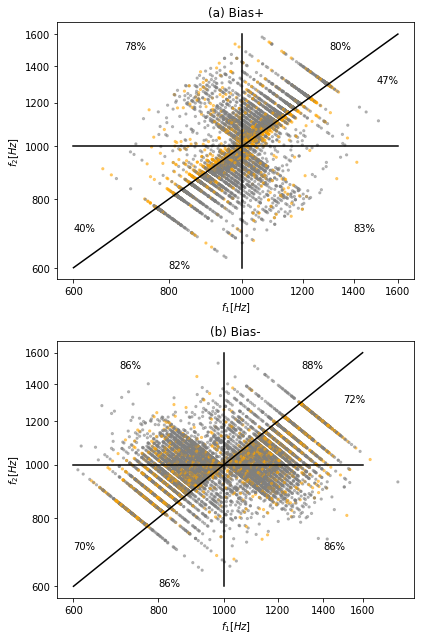

In [82]:
import matplotlib.ticker as ticker
plt.figure(figsize=(4*1.5, 3*1.5*2))
ax = plt.subplot(211)
ax.set_title("(a) Bias+")
plot_trials(bplus['freqs'], bplus['marks'])
bplus['areas'], bplus['marks_per_area'] = performance_per_area(bplus['freqs'], bplus['marks'])
plot_marks_per_area(bplus['marks_per_area'])

ax = plt.subplot(212)
ax.set_title("(b) Bias-")
plot_trials(bminus['freqs'], bminus['marks'])
bminus['areas'], bminus['marks_per_area'] = performance_per_area(bminus['freqs'], bminus['marks'])
plot_marks_per_area(bminus['marks_per_area'])

plt.tight_layout()

In [25]:
bplus['model_marks'] = run_experiment(0.1, 0.2, bplus['freqs'])
bminus['model_marks'] = run_experiment(0.1, 0.2, bminus['freqs'])

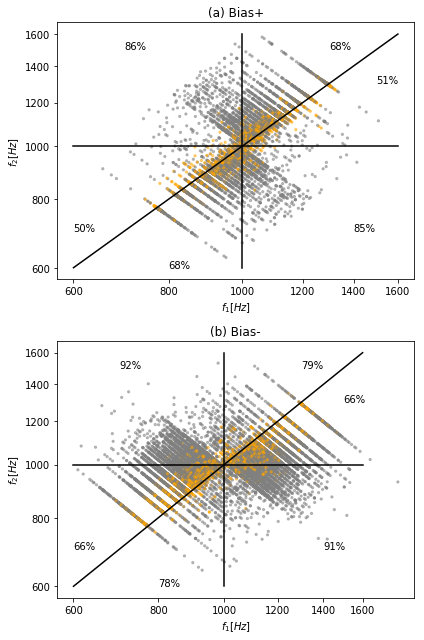

In [26]:
plt.figure(figsize=(4*1.5, 3*1.5*2))
ax = plt.subplot(211)
ax.set_title("(a) Bias+")
plot_trials(bplus['freqs'], bplus['model_marks'])
_, bplus['model_marks_per_area'] = performance_per_area(bplus['freqs'], bplus['model_marks'])
plot_marks_per_area(bplus['model_marks_per_area'])

ax = plt.subplot(212)
ax.set_title("(b) Bias-")
plot_trials(bminus['freqs'], bminus['model_marks'])
_, bminus['model_marks_per_area'] = performance_per_area(bminus['freqs'], bminus['model_marks'])
plot_marks_per_area(bminus['model_marks_per_area'])

plt.tight_layout()

Text(0.5, 0, '$f_1$ [Hz]')

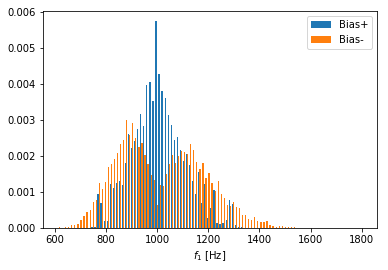

In [86]:
plt.hist([np.sort(bplus['f1'].flatten()), np.sort(bminus['f1'].flatten())], bins=100, density=True)
plt.legend(['Bias+', 'Bias-'])
plt.xlabel('$f_1$ [Hz]')

In [200]:
np.abs(bplus['f1'] - bplus['f2']).mean()

44.92883784759841

In [201]:
np.abs(bminus['f1'] - bminus['f2']).mean()

115.5724243528983